In [1]:
import numpy as np
import glob
import glob
import os.path
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import re
import datetime
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
from skimage import draw
from scipy.sparse import csr_matrix,linalg
#import spams
import time
import math
from keras.models import Sequential,model_from_json, Input,Model
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout,ReLU,Activation
from keras.preprocessing import image
import keras.backend as K
import random
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook as tqdm 
#from tensorflow.keras.callbacks import TensorBoard
import keras
from tensorboard import version
from keras.models import model_from_json

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.2
#config.gpu_options.allow_growth=True ##to use gpu as needed
config.log_device_placement = True  
sess = tf.Session(config=config)
set_session(sess)




/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BORDER_VALUE=255
NUCLEUS_VALUE=127
BG_VALUE=0
new_name=glob.glob('/datalab/nuclei_seg/png_images/*.PNG')
def rot_image(img):
    test=img.copy()
    rot=imutils.rotate(test,270)
    rot=cv2.flip(rot,1)
    return rot

def poly2boundry(x,y,img_array):
    if len(x)==2 and len(y)==2:
        rr,cc=draw.line(x[0],y[0],x[1],y[1])
    else:
        rr, cc = draw.polygon_perimeter(x, y)
    img_array[rr,cc]=[BORDER_VALUE]
    return img_array

def check_in_bounds(x,y,bound):

    if x>=bound:
        x=bound-1
    if y>=bound:
        y=bound-1
    if x<0:
        x=0
    if y<0:
        y=0
    return x,y

name=new_name[0]
new_name=name.replace('png_images','binary_images')
xml_name=name.replace('/datalab/nuclei_seg/png_images/','/datalab/nuclei_seg/Annotations/')
xml_name=xml_name.replace('.PNG','.xml')
tree=ET.parse(xml_name)
root=tree.getroot()





In [3]:
vt=[x for x in root.iter('Vertices')]
print(len(vt))

390


In [10]:
img_test=np.zeros(shape=(1000,1000),dtype=np.uint8)
print("The number of regions :{}".format(len([v.tag for v in root.iter('Vertices')])))
v=vt[0]
X=[]
Y=[]
print(len([c.tag for c in v]))
for child in v:
    
    x=int(eval(child.attrib['X']))
    y=int(eval(child.attrib['Y']))
    x,y=check_in_bounds(x,y,1000)



    X.append(x)
    Y.append(y)

img_temp=np.zeros(shape=(1000,1000),dtype=np.uint8)
r_nucleus,c_nucleus=draw.polygon(X,Y)
img_test[r_nucleus,c_nucleus]=NUCLEUS_VALUE
img_temp[r_nucleus,c_nucleus]=NUCLEUS_VALUE

img_test=poly2boundry(X,Y,img_test)

area_nuc=len(r_nucleus)
area_eroded=area_nuc
kernel=np.ones((3,3),dtype=np.uint8)


while area_eroded>0.4*area_nuc:

    area_eroded=len(np.where(img_temp==NUCLEUS_VALUE)[0])
    img_temp=cv2.erode(img_temp,kernel,iterations=1)
    

img_test.dtype=np.uint8
x,y=np.where(img_test==255)
for i,a in enumerate(x):
    img_test[a-1:a+2,y[i]-1:y[i]+2]=BORDER_VALUE
    img_test.dtype='uint8'
    
img_test[np.where(img_temp==NUCLEUS_VALUE)]=63
img_test=rot_image(img_test)


#cv2.imwrite(new_name,img_test)

print("DONE")



The number of regions :390
488
DONE


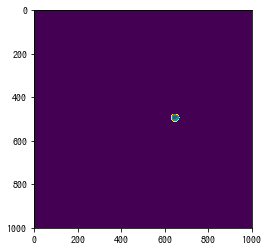

In [11]:
plt.imshow(img_test)